**Topic modelling for news articles**

In [1]:
#%pip install gensim
#%pip install pyLDAvis
#%pip install --upgrade numexpr
#%pip install --upgrade bottleneck
#%pip install openpyxl
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis.gensim_models
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alicjadorobis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alicjadorobis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# the data has previously been translated

#load the data into a dataframe
df = pd.read_excel('3800_reviews_english.xlsx')

display(df)

#removing line spacing and 'at' symbols
df = df.replace('\n',' ', regex=True)
df = df.replace('\xa0',' ', regex=True)
df.loc[df['review_text_english'].str.strip() == 'into', 'review_text_english'] = ''

# store text in a new list
article_text = df['review_text_english'].to_list()

# check the text 
article_text[22:]


,query,name,google_id,place_id,location_link,reviews_link,reviews,rating,review_id,review_pagination_id,...,review_rating,review_timestamp,review_datetime_utc,review_likes,reviews_id,reviews_per_score_1,reviews_per_score_2,reviews_per_score_3,reviews_per_score_4,reviews_per_score_5
0,ChIJCwHQg38JxkcRJeVtM9mPCnM,OV-Fiets,0x47c6097f83d0010b:0x730a8fd9336de525,ChIJCwHQg38JxkcRJeVtM9mPCnM,https://www.google.com/maps/place/OV-Fiets/@52...,https://search.google.com/local/reviews?placei...,34,3.2,ChdDSUhNMG9nS0VJQ0FnSUNsMV9lcHJBRRAB,CAESBkVnSUlBUQ==,...,1,1701202705,11/28/2023 20:18:25,0,8.289596e+18,13,1,1,3,16
1,ChIJCwHQg38JxkcRJeVtM9mPCnM,OV-Fiets,0x47c6097f83d0010b:0x730a8fd9336de525,ChIJCwHQg38JxkcRJeVtM9mPCnM,https://www.google.com/maps/place/OV-Fiets/@52...,https://search.google.com/local/reviews?placei...,34,3.2,ChZDSUhNMG9nS0VJQ0FnSUM1dHItVmN3EAE,CAESBkVnSUlBZw==,...,2,1697189187,10/13/2023 09:26:27,0,8.289596e+18,13,1,1,3,16
2,ChIJCwHQg38JxkcRJeVtM9mPCnM,OV-Fiets,0x47c6097f83d0010b:0x730a8fd9336de525,ChIJCwHQg38JxkcRJeVtM9mPCnM,https://www.google.com/maps/place/OV-Fiets/@52...,https://search.google.com/local/reviews?placei...,34,3.2,ChZDSUhNMG9nS0VJQ0FnSUNnc0p2aEh3EAE,CAESBkVnSUlBdw==,...,5,1512381515,12/04/2017 09:58:35,1,8.289596e+18,13,1,1,3,16
3,ChIJCwHQg38JxkcRJeVtM9mPCnM,OV-Fiets,0x47c6097f83d0010b:0x730a8fd9336de525,ChIJCwHQg38JxkcRJeVtM9mPCnM,https://www.google.com/maps/place/OV-Fiets/@52...,https://search.google.com/local/reviews?placei...,34,3.2,ChZDSUhNMG9nS0VJQ0FnSURRek5pUlJBEAE,CAESBkVnSUlCQQ==,...,1,1533110248,08/01/2018 07:57:28,2,8.289596e+18,13,1,1,3,16
4,ChIJCwHQg38JxkcRJeVtM9mPCnM,OV-Fiets,0x47c6097f83d0010b:0x730a8fd9336de525,ChIJCwHQg38JxkcRJeVtM9mPCnM,https://www.google.com/maps/place/OV-Fiets/@52...,https://search.google.com/local/reviews?placei...,34,3.2,ChdDSUhNMG9nS0VJQ0FnSURXNE5MOGtRRRAB,CAESBkVnSUlCUQ==,...,5,1647080014,03/12/2022 10:13:34,1,8.289596e+18,13,1,1,3,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3830,ChIJGU-a6R8XxkcR5cxWLxQYpgs,OV Fietsen,0x47c6171fe99a4f19:0xba618142f56cce5,ChIJGU-a6R8XxkcR5cxWLxQYpgs,https://www.google.com/maps/place/OV+Fietsen/@...,https://search.google.com/local/reviews?placei...,10,4.0,ChdDSUhNMG9nS0VJQ0FnSUNaal8tWTZRRRAB,CAESBkVnSUlCZw==,...,4,1695228993,09/20/2023 16:56:33,0,8.393849e+17,1,0,2,2,5
3831,ChIJGU-a6R8XxkcR5cxWLxQYpgs,OV Fietsen,0x47c6171fe99a4f19:0xba618142f56cce5,ChIJGU-a6R8XxkcR5cxWLxQYpgs,https://www.google.com/maps/place/OV+Fietsen/@...,https://search.google.com/local/reviews?placei...,10,4.0,ChdDSUhNMG9nS0VJQ0FnSUQyaUpDUTJnRRAB,CAESBkVnSUlCdw==,...,5,1651678515,05/04/2022 15:35:15,0,8.393849e+17,1,0,2,2,5
3832,ChIJGU-a6R8XxkcR5cxWLxQYpgs,OV Fietsen,0x47c6171fe99a4f19:0xba618142f56cce5,ChIJGU-a6R8XxkcR5cxWLxQYpgs,https://www.google.com/maps/place/OV+Fietsen/@...,https://search.google.com/local/reviews?placei...,10,4.0,ChdDSUhNMG9nS0VJQ0FnSUMwZzhISXF3RRAB,CAESBkVnSUlDQQ==,...,5,1570529410,10/08/2019 10:10:10,0,8.393849e+17,1,0,2,2,5
3833,ChIJGU-a6R8XxkcR5cxWLxQYpgs,OV Fietsen,0x47c6171fe99a4f19:0xba618142f56cce5,ChIJGU-a6R8XxkcR5cxWLxQYpgs,https://www.google.com/maps/place/OV+Fietsen/@...,https://search.google.com/local/reviews?placei...,10,4.0,ChZDSUhNMG9nS0VJQ0FnSUQyMDZMcldBEAE,CAESBkVnSUlDUQ==,...,4,1653385071,05/24/2022 09:37:51,0,8.393849e+17,1,0,2,2,5


["Danger!Danger!Tourists don't get bicycles.No chance!Only with a demonstrable place of residence in Holland .......",
 'Handy service, unfortunately not always a bicycle available immediately.',
 'Flood service',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Bad consumer service. Only used it a couple times and they failed to charge me and now I have to pay a fine of 20€. I reached out to consumer support but all they do to help is send pre written texts that don’t help at all.',
 'Terrible consumer service that doesn’t care about you. I’ve used the service a couple of times and I’ve always been automatically charged for the rides. Last time I used it was 3 months ago and they failed to charge me and now I have to pay a fine of 20 euros for an issue that was in their end. I reached out to consumer support but all they do to help is send pre written texts that don’t help at all and tell you to talk to other people. Disappointing. Not surprised to see other people having the same issue

In [3]:
import string
from nltk.tokenize import word_tokenize
#custom stopwords added after viewing the initial visualisation
custom_stopwords = ['also', 'said', 'one', 'per', 'get', 'could', 'would', 'ev', 'u', 'make', 'av', 'It', 'The', 'This', 'say', 'In', 'I', 'http','year']
def preprocess(text):
    stop_words = set(stopwords.words('english')).union(set(custom_stopwords or []))  # adding the custom stopwords and english
    lemmatizer = WordNetLemmatizer()
    
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = text.lower()
    tokens = word_tokenize(text)

    
    return [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]   #substitute tokens for text.lower().split() if nto working


processed_texts = [preprocess(text) for text in article_text]

In [4]:
# creating the corpus
dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]
corpus 

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1)],
 [(0, 2),
  (7, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 4),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 2),
  (42, 1)],
 [(0, 1),
  (9, 1),
  (14, 1),
  (18, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1)],
 [(0, 4),
  (1, 1),
  (11, 1),
  (16, 5),
  (18, 1),
  (23, 1),
  (26, 1),
  (31, 1),
  (35, 1),
  (36, 1),
  (39, 1),
  (50, 1),
  (61, 1),
  (62, 1),
  (63, 2),
  (64, 2),
  (65, 1),
  (66, 2),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 2),
  (72, 1),
  (73, 2),
 

In [11]:
from gensim.models import CoherenceModel

# the higher the coherence score the better choice of the number of topics
coherence__perplexity_list = []
 
for i in range(1,40):
    lda_model = LdaModel(corpus, num_topics=i, id2word=dictionary, passes=15)

    coherence_model = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence() #coherence
    perplexity = lda_model.log_perplexity(corpus) #perplexity

    coherence__perplexity_list.append((i, coherence_score, perplexity)) #adding to a list
    print(f"Number of Topics: {i}, Coherence Score: {coherence_score}, Perplexity: {perplexity}")



Number of Topics: 1, Coherence Score: 0.6975979053382908, Perplexity: -7.201617770483117
Number of Topics: 2, Coherence Score: 0.6313416905491962, Perplexity: -7.1372630220137045
Number of Topics: 3, Coherence Score: 0.5861804222422351, Perplexity: -7.177857281220305
Number of Topics: 4, Coherence Score: 0.638212335495427, Perplexity: -7.229821994704373
Number of Topics: 5, Coherence Score: 0.6069633201668563, Perplexity: -7.249563134945028
Number of Topics: 6, Coherence Score: 0.5563352254066585, Perplexity: -7.284909010527909
Number of Topics: 7, Coherence Score: 0.5432269102549266, Perplexity: -7.31516698615344
Number of Topics: 8, Coherence Score: 0.5605670122891263, Perplexity: -7.341200169051991
Number of Topics: 9, Coherence Score: 0.5120402953063388, Perplexity: -7.337542939786407
Number of Topics: 10, Coherence Score: 0.5289810269999937, Perplexity: -7.357274953751788
Number of Topics: 11, Coherence Score: 0.46628805528022216, Perplexity: -7.353217580863433
Number of Topics: 1

In [12]:
score_result_df_reviews = pd.DataFrame(coherence__perplexity_list, columns=['Num_Topics', 'Coherence_Score', 'Perplexity'])
display(score_result_df_reviews)
score_result_df_reviews.to_csv('Coherence_perplexity_reviews3800.csv')

,Num_Topics,Coherence_Score,Perplexity
0,1,0.697598,-7.201618
1,2,0.631342,-7.137263
2,3,0.586180,-7.177857
3,4,0.638212,-7.229822
4,5,0.606963,-7.249563
5,6,0.556335,-7.284909
6,7,0.543227,-7.315167
7,8,0.560567,-7.341200
8,9,0.512040,-7.337543
9,10,0.528981,-7.357275


In [13]:
# reading the csv
df_coherence_perplexity = pd.read_csv('Coherence_perplexity_reviews3800.csv')
display(df_coherence_perplexity)

,Unnamed: 0,Num_Topics,Coherence_Score,Perplexity
0,0,1,0.697598,-7.201618
1,1,2,0.631342,-7.137263
2,2,3,0.586180,-7.177857
3,3,4,0.638212,-7.229822
4,4,5,0.606963,-7.249563
5,5,6,0.556335,-7.284909
6,6,7,0.543227,-7.315167
7,7,8,0.560567,-7.341200
8,8,9,0.512040,-7.337543
9,9,10,0.528981,-7.357275


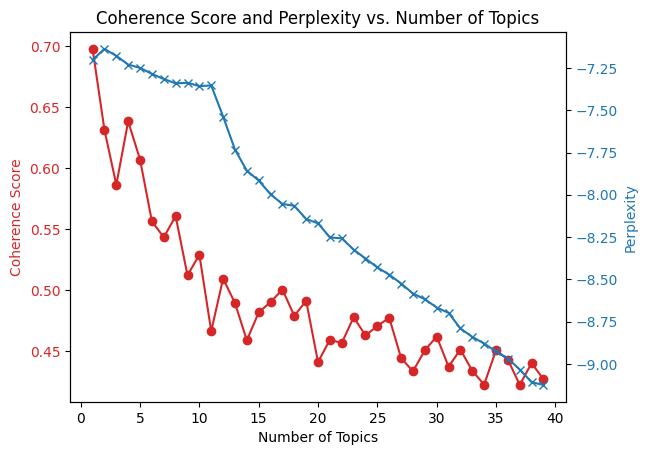

In [14]:

# Plot the results
fig, ax1 = plt.subplots()

# Plot Coherence Score on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence Score', color=color)
ax1.plot(df_coherence_perplexity['Num_Topics'], df_coherence_perplexity['Coherence_Score'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot Perplexity
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Perplexity', color=color)
ax2.plot(df_coherence_perplexity['Num_Topics'], df_coherence_perplexity['Perplexity'], color=color, marker='x')
ax2.tick_params(axis='y', labelcolor=color)

# Title and show the plot
plt.title('Coherence Score and Perplexity vs. Number of Topics')
plt.show()

In [15]:
# Apply LDA to the chose number of topics


num_topics = 3  # Change this depending on how many topics you want
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

In [16]:
# Extract topic distributions for each document 
doc_topics = [lda_model.get_document_topics(bow) for bow in corpus]

In [17]:
# first aticle
print(article_text[0])
# topics distribution within 1st article
print(doc_topics[0])

Watied 45 minutes with a guy who did not know how to work the cash register before the repairman showed up, just to discover they did not repair my flat tyre of the bike I brought in the day before. Lousy customer service. New level of not giving a f.
[(0, 0.87796617), (1, 0.014686233), (2, 0.10734764)]


In [18]:
# extract word distribution for each topic
word_topics = lda_model.print_topics()

# word distribution within topics
for idx, topic in word_topics:
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.025*"car" + 0.019*"parking" + 0.014*"good" + 0.011*"great" + 0.011*"tram" + 0.010*"public" + 0.010*"bike" + 0.010*"service" + 0.009*"utrecht" + 0.009*"day"
Topic: 1 
Words: 0.050*"parking" + 0.021*"center" + 0.018*"transport" + 0.017*"public" + 0.016*"ticket" + 0.016*"tram" + 0.015*"utrecht" + 0.014*"day" + 0.012*"euro" + 0.011*"people"
Topic: 2 
Words: 0.018*"bike" + 0.012*"parking" + 0.011*"park" + 0.011*"good" + 0.011*"go" + 0.010*"city" + 0.010*"bicycle" + 0.010*"utrecht" + 0.009*"nice" + 0.009*"station"


In [9]:
# Visualization
import pyLDAvis.gensim_models

In [10]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_visualization_3.html')